In [1]:
#Copy-and-paste the code below to use as "set-up" when your optimization model uses Pyomo and Coin-OR solvers.
#for reference, see https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/01.02-Running-Pyomo-on-Google-Colab.html#installing-pyomo-and-solvers

%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

from pyomo.environ import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
bat=pd.read_csv("fangraphsbat.csv")

In [4]:
bat.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4151 entries, 0 to 4150
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         4151 non-null   object 
 1   Team         2703 non-null   object 
 2   AB           4151 non-null   float64
 3   H            4151 non-null   float64
 4   1B           4151 non-null   float64
 5   2B           4151 non-null   float64
 6   3B           4151 non-null   float64
 7   HR           4151 non-null   float64
 8   R            4151 non-null   float64
 9   RBI          4151 non-null   float64
 10  BBB          4151 non-null   float64
 11  IBB          4151 non-null   float64
 12  BSO          4151 non-null   float64
 13  HBP          4151 non-null   float64
 14  SB           4151 non-null   float64
 15  Unnamed: 15  0 non-null      float64
 16  Unnamed: 16  0 non-null      float64
 17  Unnamed: 17  0 non-null      float64
 18  Unnamed: 18  0 non-null      float64
 19  Unname

In [5]:
# prompt: Drop columns after 14 from bat

bat = bat.iloc[:, :15]

In [6]:
bat

,Name,Team,AB,H,1B,2B,3B,HR,R,RBI,BBB,IBB,BSO,HBP,SB
0,Gunnar Henderson,BAL,596.6050,163.4080,93.8581,30.2944,5.5519,33.7037,107.0520,89.9939,74.6458,0.6842,145.3930,6.1578,17.9284
1,Aaron Judge,NYY,541.5920,147.1220,76.2358,24.1528,0.7647,45.9684,107.0440,112.6790,111.2190,15.2902,172.5510,6.6479,7.7897
2,Bobby Witt Jr.,KCR,615.8120,182.2890,107.6100,36.1092,7.7419,30.8285,107.8490,96.4291,50.2810,5.4358,105.7970,6.7947,35.7079
3,Juan Soto,NYM,537.8870,151.7600,86.5541,27.7697,2.4115,35.0245,113.0310,95.7563,128.0330,5.4108,112.2570,4.0581,8.9736
4,José Ramírez,CLE,592.6480,165.4780,96.0130,36.7228,2.5253,30.2167,93.2689,99.1015,62.0788,15.2707,80.9557,3.9837,30.5977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4146,Stone Garrett,WSN,145.2900,32.1159,20.1974,6.7671,0.2945,4.8569,16.0144,17.1767,11.5604,0.1599,49.4278,1.5990,1.4826
4147,Zach DeLoach,CHW,255.0430,56.8927,38.3318,11.3018,0.6952,6.5638,27.7440,27.8212,25.8651,0.2858,86.6635,2.2864,4.2901
4148,Jac Caglianone,KCR,55.2156,11.0315,7.7763,1.9148,0.1772,1.1632,5.2086,5.2328,2.6010,0.1773,14.9413,0.7094,0.6830
4149,Travis Bazzana,CLE,144.1680,27.3996,20.1071,4.6095,0.2916,2.3914,13.2549,12.3891,10.0099,0.0000,43.7693,1.8916,2.2297


In [7]:
# prompt: Create a new column in bat called total bases

bat['TB'] = bat['1B'] + (2 * bat['2B']) + (3 * bat['3B']) + (4 * bat['HR'])

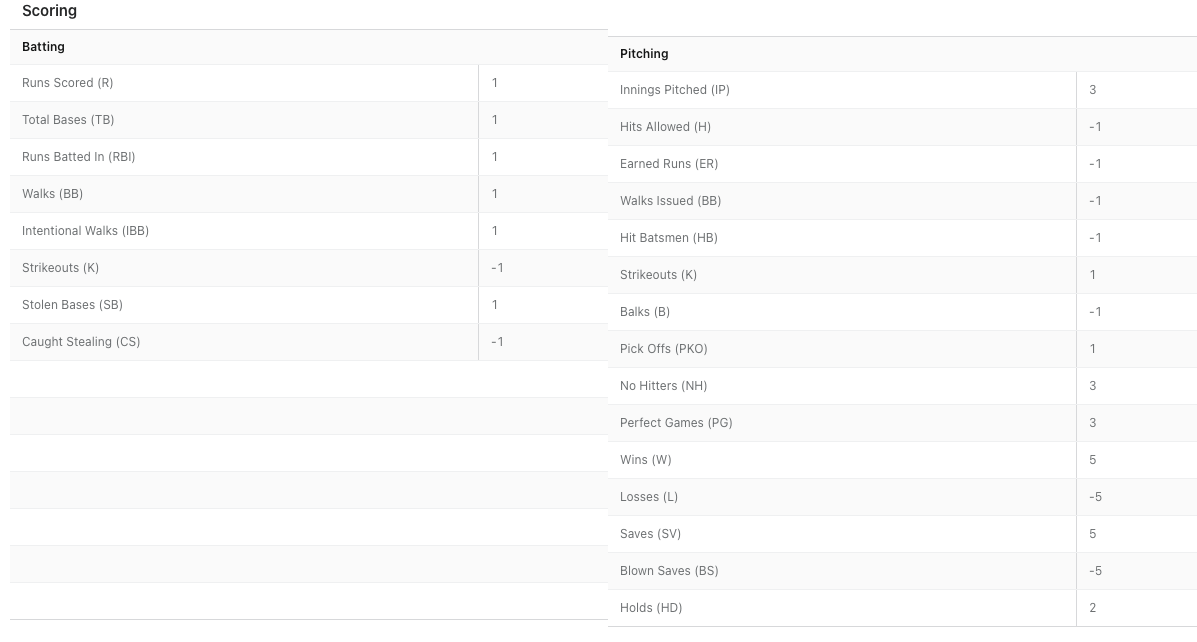

In [8]:
pitch=pd.read_csv("fangraphspitch.csv")

In [9]:
pitch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5220 entries, 0 to 5219
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    5220 non-null   object 
 1   Team    3041 non-null   object 
 2   W       5220 non-null   float64
 3   L       5220 non-null   float64
 4   SV      5220 non-null   float64
 5   HLD     5220 non-null   float64
 6   IP      5220 non-null   float64
 7   P_H     5220 non-null   float64
 8   P_R     5220 non-null   float64
 9   ER      5220 non-null   float64
 10  P_HR    5220 non-null   float64
 11  P_BB    5220 non-null   float64
 12  P_HBP   5220 non-null   float64
 13  P_SO    5220 non-null   float64
dtypes: float64(12), object(2)
memory usage: 571.1+ KB


In [10]:


# Combine the DataFrames
full= pd.merge(bat, pitch, on=['Name','Team'], how='outer')

# Fill NaN values with 0
full.fillna(0, inplace=True)

full


,Name,Team,AB,H,1B,2B,3B,HR,R,RBI,...,SV,HLD,IP,P_H,P_R,ER,P_HR,P_BB,P_HBP,P_SO
0,A.J. Alexy,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.000,1.0,0.9889,0.6119,0.57395,0.146556,0.6315,0.0499,0.8559
1,A.J. Block,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.000,1.0,1.0078,0.5310,0.49129,0.122556,0.4541,0.0546,0.8137
2,A.J. Blubaugh,HOU,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.633,22.0,20.7529,10.6489,9.88876,2.901560,7.5476,0.8987,21.1404
3,A.J. Candelario,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.000,1.0,1.0678,0.6561,0.61599,0.154333,0.6089,0.0458,0.6858
4,A.J. Ewing,NYM,0.9084,0.1469,0.1109,0.0221,0.0018,0.0121,0.0767,0.0678,...,0.0,0.000,0.0,0.0000,0.0000,0.00000,0.000000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9356,Zhiorman Imbriano,CHC,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.000,1.0,1.1836,0.7803,0.73379,0.156778,0.7995,0.0530,0.4580
9357,Zion Bannister,0,0.9221,0.1482,0.1099,0.0217,0.0024,0.0142,0.0751,0.0699,...,0.0,0.000,0.0,0.0000,0.0000,0.00000,0.000000,0.0000,0.0000,0.0000
9358,Zyhir Hope,LAD,0.9070,0.1646,0.1160,0.0239,0.0014,0.0233,0.0918,0.0891,...,0.0,0.000,0.0,0.0000,0.0000,0.00000,0.000000,0.0000,0.0000,0.0000
9359,Ángel Vargas,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0,0.000,1.0,1.1040,0.7169,0.67260,0.146000,0.7666,0.0504,0.6306


In [11]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9361 entries, 0 to 9360
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    9361 non-null   object 
 1   Team    9361 non-null   object 
 2   AB      9361 non-null   float64
 3   H       9361 non-null   float64
 4   1B      9361 non-null   float64
 5   2B      9361 non-null   float64
 6   3B      9361 non-null   float64
 7   HR      9361 non-null   float64
 8   R       9361 non-null   float64
 9   RBI     9361 non-null   float64
 10  BBB     9361 non-null   float64
 11  IBB     9361 non-null   float64
 12  BSO     9361 non-null   float64
 13  HBP     9361 non-null   float64
 14  SB      9361 non-null   float64
 15  TB      9361 non-null   float64
 16  W       9361 non-null   float64
 17  L       9361 non-null   float64
 18  SV      9361 non-null   float64
 19  HLD     9361 non-null   float64
 20  IP      9361 non-null   float64
 21  P_H     9361 non-null   float64
 22  

In [12]:
# Calculate FPTS based on the provided scoring
full['FPTS'] = (full['R'] * 1 +
                full['TB'] * 1 +
                full['RBI'] * 1 +
                full['BBB'] * 1 +
                full['IBB'] * 1 +
                full['BSO'] * -1 +
                full['SB'] * 1 +
                full['IP'] * 3 +
                full['H'] * -1 +
                full['ER'] * -2 +
                full['HLD'] * 2 +
                full['P_BB'] * -1 +
                full['P_SO'] * 1 +
                full['W'] * 5 +
                full['L'] * -5 +
                full['SV'] * 5)

full

,Name,Team,AB,H,1B,2B,3B,HR,R,RBI,...,HLD,IP,P_H,P_R,ER,P_HR,P_BB,P_HBP,P_SO,FPTS
0,A.J. Alexy,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.000,1.0,0.9889,0.6119,0.57395,0.146556,0.6315,0.0499,0.8559,2.02150
1,A.J. Block,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.000,1.0,1.0078,0.5310,0.49129,0.122556,0.4541,0.0546,0.8137,2.35352
2,A.J. Blubaugh,HOU,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.633,22.0,20.7529,10.6489,9.88876,2.901560,7.5476,0.8987,21.1404,61.20978
3,A.J. Candelario,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.000,1.0,1.0678,0.6561,0.61599,0.154333,0.6089,0.0458,0.6858,1.75642
4,A.J. Ewing,NYM,0.9084,0.1469,0.1109,0.0221,0.0018,0.0121,0.0767,0.0678,...,0.000,0.0,0.0000,0.0000,0.00000,0.000000,0.0000,0.0000,0.0000,-0.04780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9356,Zhiorman Imbriano,CHC,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.000,1.0,1.1836,0.7803,0.73379,0.156778,0.7995,0.0530,0.4580,0.93792
9357,Zion Bannister,0,0.9221,0.1482,0.1099,0.0217,0.0024,0.0142,0.0751,0.0699,...,0.000,0.0,0.0000,0.0000,0.00000,0.000000,0.0000,0.0000,0.0000,-0.06410
9358,Zyhir Hope,LAD,0.9070,0.1646,0.1160,0.0239,0.0014,0.0233,0.0918,0.0891,...,0.000,0.0,0.0000,0.0000,0.00000,0.000000,0.0000,0.0000,0.0000,0.04450
9359,Ángel Vargas,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.000,1.0,1.1040,0.7169,0.67260,0.146000,0.7666,0.0504,0.6306,1.42630


Check to see if theres anything unexpected


In [13]:
# Sort the DataFrame by FPTS in descending order and get the top 25 players
top_25_players = full.sort_values('FPTS', ascending=False).head(25)

# Display the top 25 players
print(top_25_players[['Name', 'Team', 'FPTS']])

                  Name Team      FPTS
8188     Shohei Ohtani  LAD  811.5880
8354      Tarik Skubal  DET  664.0327
7274       Paul Skenes  PIT  656.6458
1762        Chris Sale  ATL  645.7010
9346      Zack Wheeler  PHI  630.4999
5930     Logan Gilbert  SEA  617.4714
2025     Corbin Burnes    0  586.9827
7219       Pablo López  MIN  586.7151
2669       Dylan Cease  SDP  586.5971
5948        Logan Webb  SFG  585.2670
3212    Framber Valdez  HOU  574.0831
947        Blake Snell  LAD  573.2599
39          Aaron Nola  PHI  573.1294
3383   Garrett Crochet  BOS  572.5069
8214        Sonny Gray  STL  571.2734
4051      Jacob deGrom  TEX  558.1880
5614     Kevin Gausman  TOR  556.2091
8152  Shane McClanahan  TBR  555.9570
1906       Cole Ragans  KCR  555.0280
3462       Gerrit Cole  NYY  552.9308
8190     Shota Imanaga  CHC  549.2866
3434      George Kirby  SEA  548.1896
6021     Luis Castillo  SEA  541.6616
3299    Freddy Peralta  MIL  532.4005
9280        Zach Eflin  BAL  530.4423


Bring in the auction salary data for hitters and pitchers

In [14]:
salary_p=pd.read_csv("auctionpitch.csv")



In [15]:
salary_b=pd.read_csv("auctionbat.csv")

In [16]:
# Concatenate the two dataframes
salary = pd.concat([salary_p, salary_b], ignore_index=True)

# Display the combined dataframe (optional)
salary

,Name,Team,POS,rPTS,Dollars
0,Paul Skenes,PIT,SP,509.638902,41.502794
1,Tarik Skubal,DET,SP,502.969737,40.033062
2,Chris Sale,ATL,SP,493.336051,37.910018
3,Zack Wheeler,PHI,SP,459.400543,30.431406
4,Jacob deGrom,TEX,SP,442.887162,26.792234
...,...,...,...,...,...
1095,Esteury Ruiz,OAK,OF,60.624201,-56.299148
1096,Carson Williams,TBR,SS,60.224401,-54.341843
1097,Drake Baldwin,ATL,C,60.195000,-40.572193
1098,Jake Cave,NaN,OF,59.901398,-56.458437


In [17]:
salary.describe()

,rPTS,Dollars
count,1100.000000,1100.000000
mean,187.948234,-22.305825
std,104.752714,20.930336
min,39.294979,-62.150273
25%,100.488270,-38.079828
50%,158.245000,-27.201822
75%,257.574251,-9.997831
max,528.159096,50.385578


In [18]:
# Drop rows where 'Dollars' is less than -30
salary = salary[salary['Dollars'] >= -20.5]

# Now the 'salary' DataFrame contains only rows where 'Dollars' is -30 or greater
salary

,Name,Team,POS,rPTS,Dollars
0,Paul Skenes,PIT,SP,509.638902,41.502794
1,Tarik Skubal,DET,SP,502.969737,40.033062
2,Chris Sale,ATL,SP,493.336051,37.910018
3,Zack Wheeler,PHI,SP,459.400543,30.431406
4,Jacob deGrom,TEX,SP,442.887162,26.792234
...,...,...,...,...,...
917,Ivan Herrera,STL,C,181.949308,-13.740322
919,Danny Jansen,TBR,C,178.950602,-14.401169
921,Bo Naylor,CLE,C,177.605995,-14.697489
938,Hunter Goodman,COL,OF,158.730396,-18.857241


Data Quality and maintenance. The minnimum you can get a player for is 1 dollar so lets adjust to show accordingly

In [19]:
# prompt: There should be no values in the Dollars column that are less than one can you make it so that any row where Dollars is less than one just has 1


# Replace values less than 1 in the 'Dollars' column with 1
salary.loc[salary['Dollars'] < 1, 'Dollars'] = 1

# Display the combined dataframe (optional)
salary

,Name,Team,POS,rPTS,Dollars
0,Paul Skenes,PIT,SP,509.638902,41.502794
1,Tarik Skubal,DET,SP,502.969737,40.033062
2,Chris Sale,ATL,SP,493.336051,37.910018
3,Zack Wheeler,PHI,SP,459.400543,30.431406
4,Jacob deGrom,TEX,SP,442.887162,26.792234
...,...,...,...,...,...
917,Ivan Herrera,STL,C,181.949308,1.000000
919,Danny Jansen,TBR,C,178.950602,1.000000
921,Bo Naylor,CLE,C,177.605995,1.000000
938,Hunter Goodman,COL,OF,158.730396,1.000000


Another quality check to see if we see any irregularities

In [20]:
# prompt: Can you show me the highest salaries

# Sort the salary DataFrame by 'Dollars' in descending order and display the top entries
highest_salaries = salary.sort_values('Dollars', ascending=False)
print(highest_salaries[['Name', 'Dollars']])

               Name    Dollars
663    Jose Ramirez  50.385578
661       Juan Soto  46.484088
662  Bobby Witt Jr.  46.460551
660   Shohei Ohtani  44.432398
664    Mookie Betts  42.003182
..              ...        ...
147        Jon Gray   1.000000
146  Gavin Williams   1.000000
145     Clay Holmes   1.000000
144  Edward Cabrera   1.000000
153    Kevin Ginkel   1.000000

[426 rows x 2 columns]


In [21]:
# performing an inner join to keep only players present in both datasets.
merged_df = pd.merge(full, salary, on=['Name','Team'], how='inner')

# Select the desired columns from the merged DataFrame
final_df = merged_df[['Name', 'Team','POS', 'Dollars', 'FPTS','TB', 'R', 'HR','RBI', 'BBB', 'IBB', 'BSO', 'HBP', 'W', 'L', 'SV', 'HLD', 'IP', 'P_H','P_R', 'ER', 'P_HR', 'P_BB', 'P_HBP', 'P_SO']]

# Display the final DataFrame
final_df


,Name,Team,POS,Dollars,FPTS,TB,R,HR,RBI,BBB,...,SV,HLD,IP,P_H,P_R,ER,P_HR,P_BB,P_HBP,P_SO
0,A.J. Puk,ARI,RP,1.000000,278.4907,0.0000,0.0000,0.0000,0.000,0.0000,...,9.087,10.4349,68.000,57.2171,27.7213,25.5731,6.99644,23.6656,3.2930,79.1657
1,Aaron Bummer,ATL,RP,1.000000,227.5609,0.0000,0.0000,0.0000,0.000,0.0000,...,1.069,14.3343,62.000,53.2312,23.6892,21.2681,4.37444,24.3576,2.8815,69.3816
2,Aaron Civale,MIL,SP,1.000000,374.8059,0.0000,0.0000,0.0000,0.000,0.0000,...,0.000,0.0000,142.910,142.5850,74.9888,70.0554,23.11960,42.4833,6.4623,134.8650
3,Aaron Judge,NYY,OF,36.901578,345.0580,310.7091,107.0440,45.9684,112.679,111.2190,...,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000
4,Aaron Nola,PHI,SP,14.649254,573.1294,0.0000,0.0000,0.0000,0.000,0.0000,...,0.000,0.0000,195.106,185.3430,89.8895,83.0612,27.24980,46.6672,6.1705,192.4510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,Yusei Kikuchi,LAA,SP,10.802603,527.5052,0.0000,0.0000,0.0000,0.000,0.0000,...,0.000,0.0000,176.110,157.1720,79.3761,73.5915,24.44010,54.7048,6.0283,195.9560
351,Zac Gallen,ARI,SP,5.548043,522.8520,0.0000,0.0000,0.0000,0.000,0.0000,...,0.000,0.0000,182.850,176.3650,86.5175,79.8656,21.21070,56.4623,7.2262,183.8540
352,Zach Eflin,BAL,SP,4.737170,530.4423,0.0000,0.0000,0.0000,0.000,0.0000,...,0.000,0.0000,185.620,187.6350,85.6617,78.9024,25.07940,32.3239,6.2640,155.8090
353,Zach Neto,LAA,SS,1.064330,173.1370,220.1392,68.9066,21.2927,68.372,38.5262,...,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000


In [22]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 25 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Name     355 non-null    object 
 1   Team     355 non-null    object 
 2   POS      355 non-null    object 
 3   Dollars  355 non-null    float64
 4   FPTS     355 non-null    float64
 5   TB       355 non-null    float64
 6   R        355 non-null    float64
 7   HR       355 non-null    float64
 8   RBI      355 non-null    float64
 9   BBB      355 non-null    float64
 10  IBB      355 non-null    float64
 11  BSO      355 non-null    float64
 12  HBP      355 non-null    float64
 13  W        355 non-null    float64
 14  L        355 non-null    float64
 15  SV       355 non-null    float64
 16  HLD      355 non-null    float64
 17  IP       355 non-null    float64
 18  P_H      355 non-null    float64
 19  P_R      355 non-null    float64
 20  ER       355 non-null    float64
 21  P_HR     355 non

In [23]:
final_df

,Name,Team,POS,Dollars,FPTS,TB,R,HR,RBI,BBB,...,SV,HLD,IP,P_H,P_R,ER,P_HR,P_BB,P_HBP,P_SO
0,A.J. Puk,ARI,RP,1.000000,278.4907,0.0000,0.0000,0.0000,0.000,0.0000,...,9.087,10.4349,68.000,57.2171,27.7213,25.5731,6.99644,23.6656,3.2930,79.1657
1,Aaron Bummer,ATL,RP,1.000000,227.5609,0.0000,0.0000,0.0000,0.000,0.0000,...,1.069,14.3343,62.000,53.2312,23.6892,21.2681,4.37444,24.3576,2.8815,69.3816
2,Aaron Civale,MIL,SP,1.000000,374.8059,0.0000,0.0000,0.0000,0.000,0.0000,...,0.000,0.0000,142.910,142.5850,74.9888,70.0554,23.11960,42.4833,6.4623,134.8650
3,Aaron Judge,NYY,OF,36.901578,345.0580,310.7091,107.0440,45.9684,112.679,111.2190,...,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000
4,Aaron Nola,PHI,SP,14.649254,573.1294,0.0000,0.0000,0.0000,0.000,0.0000,...,0.000,0.0000,195.106,185.3430,89.8895,83.0612,27.24980,46.6672,6.1705,192.4510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,Yusei Kikuchi,LAA,SP,10.802603,527.5052,0.0000,0.0000,0.0000,0.000,0.0000,...,0.000,0.0000,176.110,157.1720,79.3761,73.5915,24.44010,54.7048,6.0283,195.9560
351,Zac Gallen,ARI,SP,5.548043,522.8520,0.0000,0.0000,0.0000,0.000,0.0000,...,0.000,0.0000,182.850,176.3650,86.5175,79.8656,21.21070,56.4623,7.2262,183.8540
352,Zach Eflin,BAL,SP,4.737170,530.4423,0.0000,0.0000,0.0000,0.000,0.0000,...,0.000,0.0000,185.620,187.6350,85.6617,78.9024,25.07940,32.3239,6.2640,155.8090
353,Zach Neto,LAA,SS,1.064330,173.1370,220.1392,68.9066,21.2927,68.372,38.5262,...,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000


Now we should have it all condensed into one DF. lets check for any things that don't look right.

In [24]:
# Sort the merged DataFrame by FPTS in descending order and get the top 50 players
top_50_players = final_df.sort_values('FPTS', ascending=False).head(50)

# Display the top 50 players with their names, teams, FPTS, and dollars
print(top_50_players[['Name', 'Team', 'FPTS', 'Dollars','POS']])

                      Name Team      FPTS    Dollars POS
303          Shohei Ohtani  LAD  811.5880  44.432398  OF
302          Shohei Ohtani  LAD  811.5880   1.000000  SP
318           Tarik Skubal  DET  664.0327  40.033062  SP
266            Paul Skenes  PIT  656.6458  41.502794  SP
58              Chris Sale  ATL  645.7010  37.910018  SP
354           Zack Wheeler  PHI  630.4999  30.431406  SP
202          Logan Gilbert  SEA  617.4714  26.427759  SP
86             Dylan Cease  SDP  586.5971  24.005965  SP
204             Logan Webb  SFG  585.2670  13.444659  SP
103         Framber Valdez  HOU  574.0831  15.422552  SP
21             Blake Snell  LAD  573.2599  24.133576  SP
4               Aaron Nola  PHI  573.1294  14.649254  SP
111        Garrett Crochet  BOS  572.5069  26.700360  SP
305             Sonny Gray  STL  571.2734  18.627622  SP
138           Jacob deGrom  TEX  558.1880  26.792234  SP
187          Kevin Gausman  TOR  556.2091  11.828550  SP
301       Shane McClanahan  TBR

Shohei Ohtani is double listed as he is both a pitcher and a hitter one of them in fact didn't bring in his salary correctly so lets remove that occurance of him as in real life the user will have the option as to whether they want to have him hit or pitch for that team on a given day/week

In [25]:


final_df.iloc[302]


,302
Name,Shohei Ohtani
Team,LAD
POS,SP
Dollars,1.0
FPTS,811.588
TB,335.0514
R,122.831
HR,43.0829
RBI,104.403
BBB,85.2185


Remove the second Shohei Ohtani

In [27]:

# Remove the row at index 302
final_df = final_df.drop(index=302)



KeyError: '[302] not found in axis'

Now lets optimize the model.


The Input parameters are The Budget, the number of Required players, and the positional requirements

In [28]:



# Create a dictionary for player positions
player_positions = dict(zip(final_df['Name'], final_df['POS']))

# Parameters
budget = 260  # Auction budget
required_players = 24  # Total number of starters

# Number of players required for each position
position_requirements = {
    'C': 2,
    '1B': 2,
    '2B': 2,
    'SS': 2,
    '3B': 2,
    'OF': 5,
    'RP': 3,
    'SP': 6
}

# Model
model = ConcreteModel()

# Sets and Variables
player_names = final_df['Name'].tolist()
model.players = Set(initialize=player_names)
model.select = Var(model.players, within=Binary)  # 0 or 1: whether to draft the player

# Objective: Maximize total FPTS contribution
def objective_function(model):
    return sum(
        model.select[player] * final_df.loc[final_df['Name'] == player, 'FPTS'].values[0]
        for player in player_names
    )

model.objective = Objective(rule=objective_function, sense=maximize)

# Constraint: Budget
def budget_constraint(model):
    return sum(
        model.select[player] * final_df.loc[final_df['Name'] == player, 'Dollars'].values[0]
        for player in player_names
    ) <= budget

model.budget_constraint = Constraint(rule=budget_constraint)

# Constraint: Total players
def player_count_constraint(model):
    return sum(model.select[player] for player in player_names) == required_players

model.player_count_constraint = Constraint(rule=player_count_constraint)

# Constraints: Position requirements
model.position_constraints = ConstraintList()
for position, required_count in position_requirements.items():
    model.position_constraints.add(
        sum(model.select[player] for player in player_names if player_positions[player] == position) == required_count
    )

# Solve
solver = SolverFactory('cbc')
results = solver.solve(model)

# Output results
selected_players = [player for player in player_names if model.select[player]() > 0.5]
print("Selected Players:")
for player in selected_players:
    print(player)

# Export results
selected_df = final_df[final_df['Name'].isin(selected_players)]
selected_df.to_csv("selected_team.csv", index=False)
print("Selected team saved to selected_team.csv")


Selected Players:
Aaron Judge
Aaron Nola
Alejandro Kirk
Bryson Stott
Carlos Correa
Christian Yelich
Corey Seager
Emmanuel Clase
Framber Valdez
Francisco Alvarez
Kevin Gausman
Kyle Schwarber
Logan Webb
Max Muncy
Mike Trout
Nico Hoerner
Raisel Iglesias
Royce Lewis
Ryan Walker
Seth Lugo
Shohei Ohtani
Spencer Steer
Triston Casas
Zach Eflin
Selected team saved to selected_team.csv


Lets look at the team we got.

In [29]:
selected_df

,Name,Team,POS,Dollars,FPTS,TB,R,HR,RBI,BBB,...,SV,HLD,IP,P_H,P_R,ER,P_HR,P_BB,P_HBP,P_SO
3,Aaron Judge,NYY,OF,36.901578,345.0580,310.7091,107.0440,45.9684,112.6790,111.2190,...,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000
4,Aaron Nola,PHI,SP,14.649254,573.1294,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.000,0.0000,195.106,185.3430,89.8895,83.0612,27.24980,46.6672,6.1705,192.4510
8,Alejandro Kirk,TOR,C,1.000000,140.3926,155.0035,48.2343,10.6661,48.5591,42.0691,...,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000
45,Bryson Stott,PHI,2B,2.674383,190.5927,220.4276,70.8199,14.5706,66.0966,52.9502,...,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000
53,Carlos Correa,MIN,SS,4.599377,189.2762,228.3058,77.7874,19.3895,68.6677,62.4218,...,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000
60,Christian Yelich,MIL,OF,7.646555,210.6292,226.7297,84.8863,18.0504,67.7047,76.1507,...,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000
72,Corey Seager,TEX,SS,19.890204,257.6140,260.4040,87.6307,28.9046,80.6724,58.8471,...,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000
95,Emmanuel Clase,CLE,RP,16.210041,394.5050,0.0000,0.0000,0.0000,0.0000,0.0000,...,34.380,1.0609,70.000,64.4644,26.8568,24.2235,5.76333,16.5942,2.3239,71.6869
103,Framber Valdez,HOU,SP,15.422552,574.0831,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.000,0.0000,194.848,182.7860,82.4597,74.4426,16.51870,62.3132,9.0721,187.3760
104,Francisco Alvarez,NYM,C,1.000000,140.6129,182.5024,57.7453,21.1903,62.1449,43.2860,...,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000


Lets make sure the position requirements were met

In [30]:
value_counts = selected_df['POS'].value_counts()

print(value_counts)

POS
SP    6
OF    5
RP    3
C     2
2B    2
SS    2
3B    2
1B    2
Name: count, dtype: int64


Lets check out the stats and ensure we didn't go over budget

In [31]:
# prompt: Can you ccalculate summation stats for selected_df

# Calculate summation statistics for selected_df
summation_stats = selected_df[['FPTS', 'Dollars', 'TB', 'R', 'RBI', 'HR','BBB', 'IBB', 'BSO', 'HBP', 'W', 'L', 'SV', 'HLD', 'IP', 'P_H', 'P_R', 'ER', 'P_HR', 'P_BB', 'P_HBP', 'P_SO']].sum()
summation_stats

,0
FPTS,8193.491300
Dollars,259.918487
TB,3521.270100
R,1198.502600
RBI,1142.714900
HR,379.565200
BBB,1010.826300
IBB,68.994300
BSO,1923.412500
HBP,87.791200


## Now lets compare it to a random team that meets the constraints but doesn't maximize fantasy points

In [32]:
import pandas as pd
import numpy as np
from random import sample

# Input Parameters
budget = 260  # Auction budget
required_players = 24  # Total number of starters

# Number of players required for each position
position_requirements = {
    'C': 2,
    '1B': 2,
    '2B': 2,
    'SS': 2,
    '3B': 2,
    'OF': 5,
    'RP': 3,
    'SP': 6
}

# Create lists to store selected players and remaining budget
selected_players = []
remaining_budget = budget

# Randomly select players while meeting position requirements
for position, required_count in position_requirements.items():
    # Get a list of available players for the current position
    available_players = final_df[final_df['POS'] == position].copy()
    available_players = available_players[~available_players['Name'].isin(selected_players)]

    # Randomly select the required number of players for the position
    for _ in range(required_count):
        if not available_players.empty:
            selected_player = available_players.sample(n=1).iloc[0]
            if selected_player['Dollars'] <= remaining_budget:
                selected_players.append(selected_player['Name'])
                remaining_budget -= selected_player['Dollars']
            available_players = available_players[available_players['Name'] != selected_player['Name']]

# Check if the total number of players is met and adjust if necessary
if len(selected_players) < required_players:
    remaining_players_needed = required_players - len(selected_players)
    remaining_players = final_df[~final_df['Name'].isin(selected_players)].copy()
    remaining_players = remaining_players[remaining_players['Dollars'] <= remaining_budget]

    if len(remaining_players) >= remaining_players_needed:
        additional_players = remaining_players.sample(n=remaining_players_needed)
        selected_players.extend(additional_players['Name'].tolist())
    else:
        print("Not enough remaining players within the budget to meet the total player requirement.")

# Sort initially selected players by 'Dollars' (ascending)
selected_df = final_df[final_df['Name'].isin(selected_players)]
sorted_selected = selected_df.sort_values(by='Dollars').copy()

# Budget optimization: Replace cheap players with more expensive ones
while remaining_budget > 0:
    # Get the cheapest player
    cheapest_player = sorted_selected.iloc[0]

    # Find a more expensive replacement player within the same position
    position = cheapest_player['POS']
    available_replacements = final_df[
        (final_df['POS'] == position) &
        (~final_df['Name'].isin(selected_players)) &
        (final_df['Dollars'] > cheapest_player['Dollars']) &
        (final_df['Dollars'] <= (remaining_budget + cheapest_player['Dollars']))
    ]

    if not available_replacements.empty:
        # Select a random replacement player
        replacement_player = available_replacements.sample(n=1).iloc[0]

        # Replace the cheapest player with the new one
        selected_players.remove(cheapest_player['Name'])
        selected_players.append(replacement_player['Name'])
        remaining_budget += cheapest_player['Dollars'] - replacement_player['Dollars']

        # Update the sorted list of selected players
        sorted_selected = final_df[final_df['Name'].isin(selected_players)].sort_values(by='Dollars')
    else:
        # No valid replacement found, break the loop
        break

# Output results
print("Randomly Selected Players:")
for player in selected_players:
    print(player)

# Show remaining budget
print(f"Final Budget Used: {budget - remaining_budget}")
print(f"Remaining Budget: {remaining_budget}")

# Export results
random_df = final_df[final_df['Name'].isin(selected_players)]
random_df.to_csv("random_team.csv", index=False)
print("Random team saved to random_team.csv")


Randomly Selected Players:
Ryan O'Hearn
Vinnie Pasquantino
Jose Altuve
Nico Hoerner
Carlos Correa
Willi Castro
Lourdes Gurriel Jr.
Reed Garrett
Keegan Akin
Sandy Alcantara
Kevin Gausman
Corbin Carroll
MacKenzie Gore
Jacob deGrom
Jose Miranda
Will Smith
Aaron Nola
Paul Skenes
Bryan Reynolds
Jordan Westburg
Keibert Ruiz
Randy Arozarena
Steven Kwan
Devin Williams
Final Budget Used: 259.67316304099995
Remaining Budget: 0.32683695900004395
Random team saved to random_team.csv


In [33]:
random_df

,Name,Team,POS,Dollars,FPTS,TB,R,HR,RBI,BBB,...,SV,HLD,IP,P_H,P_R,ER,P_HR,P_BB,P_HBP,P_SO
4,Aaron Nola,PHI,SP,14.649254,573.1294,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.000,0.0000,195.106,185.3430,89.8895,83.0612,27.24980,46.6672,6.1705,192.4510
41,Bryan Reynolds,PIT,OF,9.424380,197.0004,262.8097,88.9152,24.1818,78.8769,58.4630,...,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000
53,Carlos Correa,MIN,SS,4.599377,189.2762,228.3058,77.7874,19.3895,68.6677,62.4218,...,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000
71,Corbin Carroll,ARI,OF,32.919783,299.8645,281.5712,105.5960,25.6787,81.2723,71.4265,...,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000
82,Devin Williams,NYY,RP,8.110126,341.4078,0.0000,0.0000,0.0000,0.0000,0.0000,...,26.056,4.7762,63.000,48.1219,24.3822,22.2958,6.27900,27.6623,2.7514,81.0338
138,Jacob deGrom,TEX,SP,26.792234,558.1880,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.000,0.0000,152.018,115.2990,52.0743,47.9781,17.00910,30.0238,4.9240,205.9070
166,Jordan Westburg,BAL,3B,1.896999,151.6480,218.7826,65.5123,18.5782,68.6325,37.9680,...,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000
168,Jose Altuve,HOU,2B,16.243933,227.1018,268.7280,96.1871,22.4880,71.5429,56.8853,...,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000
169,Jose Miranda,MIN,3B,1.139719,146.3774,207.1242,58.3009,14.9969,63.2375,31.6733,...,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.0000
183,Keegan Akin,BAL,RP,1.000000,260.5263,0.0000,0.0000,0.0000,0.0000,0.0000,...,1.009,14.6680,72.000,61.8297,28.6062,26.4064,8.69600,21.1108,2.3750,79.7584


In [34]:
import pandas as pd
import numpy as np
from random import sample

# Input Parameters
budget = 260  # Auction budget
required_players = 24  # Total number of starters

# Number of players required for each position
position_requirements = {
    'C': 2,
    '1B': 2,
    '2B': 2,
    'SS': 2,
    '3B': 2,
    'OF': 5,
    'RP': 3,
    'SP': 6
}

# Columns to calculate summation stats
stat_columns = ['FPTS', 'Dollars', 'TB', 'R', 'RBI', 'HR', 'BBB', 'IBB', 'BSO', 'HBP',
                'W', 'L', 'SV', 'HLD', 'IP', 'P_H', 'P_R', 'ER', 'P_HR', 'P_BB', 'P_HBP', 'P_SO']

# Function to generate a single random team
def generate_random_team(final_df, budget, required_players, position_requirements):
    selected_players = []
    remaining_budget = budget

    # Randomly select players while meeting position requirements
    for position, required_count in position_requirements.items():
        available_players = final_df[final_df['POS'] == position].copy()
        available_players = available_players[~available_players['Name'].isin(selected_players)]

        for _ in range(required_count):
            if not available_players.empty:
                selected_player = available_players.sample(n=1).iloc[0]
                if selected_player['Dollars'] <= remaining_budget:
                    selected_players.append(selected_player['Name'])
                    remaining_budget -= selected_player['Dollars']
                available_players = available_players[available_players['Name'] != selected_player['Name']]

    # Check if the total number of players is met and adjust if necessary
    if len(selected_players) < required_players:
        remaining_players_needed = required_players - len(selected_players)
        remaining_players = final_df[~final_df['Name'].isin(selected_players)].copy()
        remaining_players = remaining_players[remaining_players['Dollars'] <= remaining_budget]

        if len(remaining_players) >= remaining_players_needed:
            additional_players = remaining_players.sample(n=remaining_players_needed)
            selected_players.extend(additional_players['Name'].tolist())

    # Budget optimization: Replace cheap players with more expensive ones
    selected_df = final_df[final_df['Name'].isin(selected_players)]
    sorted_selected = selected_df.sort_values(by='Dollars').copy()

    while remaining_budget > 0:
        cheapest_player = sorted_selected.iloc[0]
        position = cheapest_player['POS']
        available_replacements = final_df[
            (final_df['POS'] == position) &
            (~final_df['Name'].isin(selected_players)) &
            (final_df['Dollars'] > cheapest_player['Dollars']) &
            (final_df['Dollars'] <= (remaining_budget + cheapest_player['Dollars']))
        ]

        if not available_replacements.empty:
            replacement_player = available_replacements.sample(n=1).iloc[0]
            selected_players.remove(cheapest_player['Name'])
            selected_players.append(replacement_player['Name'])
            remaining_budget += cheapest_player['Dollars'] - replacement_player['Dollars']
            sorted_selected = final_df[final_df['Name'].isin(selected_players)].sort_values(by='Dollars')
        else:
            break

    return final_df[final_df['Name'].isin(selected_players)]

# Generate 5 random teams and calculate average summation stats
random_team_stats_list = []

for i in range(5):
    print(f"Generating Team {i+1}...")
    random_team_df = generate_random_team(final_df, budget, required_players, position_requirements)
    team_stats = random_team_df[stat_columns].sum()
    random_team_stats_list.append(team_stats)

# Calculate the average summation stats across 5 teams
average_random_team_stats = pd.DataFrame(random_team_stats_list).mean()

# Output results
print("\nAverage Summation Stats for 5 Random Teams:")
print(average_random_team_stats)

# Save results to CSV
average_random_team_stats.to_csv("average_random_team_stats.csv", index=True)
print("Average stats saved to average_random_team_stats.csv")


Generating Team 1...
Generating Team 2...
Generating Team 3...
Generating Team 4...
Generating Team 5...

Average Summation Stats for 5 Random Teams:
FPTS       7206.824560
Dollars     258.987420
TB         3572.669660
R          1176.235600
RBI        1106.292480
HR          323.751580
BBB         838.356640
IBB          37.796180
BSO        1794.136660
HBP          98.368020
W            78.541900
L            67.968660
SV           76.286000
HLD          14.540120
IP         1267.689600
P_H        1124.434080
P_R         556.307820
ER          513.471280
P_HR        151.337182
P_BB        411.799640
P_HBP        48.814720
P_SO       1377.739020
dtype: float64
Average stats saved to average_random_team_stats.csv


Here are the average stats for the 5 randomly generated teams

In [35]:
average_random_team_stats

,0
FPTS,7206.824560
Dollars,258.987420
TB,3572.669660
R,1176.235600
RBI,1106.292480
HR,323.751580
BBB,838.356640
IBB,37.796180
BSO,1794.136660
HBP,98.368020


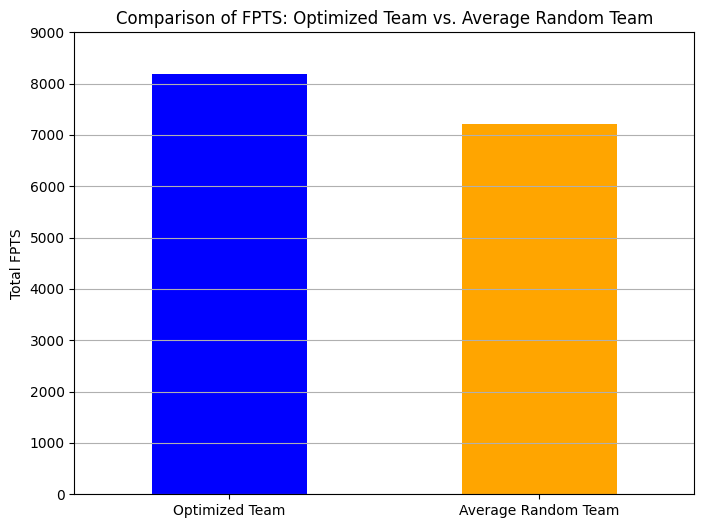

In [39]:

# Create a pandas Series for the optimized team's FPTS
optimized_team_fpts = pd.Series({'Optimized Team': summation_stats['FPTS']})

# Create a pandas Series for the average random team's FPTS
average_random_team_fpts = pd.Series({'Average Random Team': average_random_team_stats['FPTS']})

# Concatenate the two Series for plotting
comparison_fpts = pd.concat([optimized_team_fpts, average_random_team_fpts])

# Create the bar plot
plt.figure(figsize=(8, 6))
comparison_fpts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Comparison of FPTS: Optimized Team vs. Average Random Team')
plt.ylabel('Total FPTS')
plt.ylim(0, 9000) # Set y-axis limit to better visualize the difference
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()